In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from src.process_data import process_data,load_data

import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Span

In [2]:
df = process_data(fn='data/ripc_rel.csv',normalize='log2_fc')

Cached file found at ../data/ripc_rel.pk
Loading from ../data/ripc_rel.pk...


In [3]:
pop_df = pd.read_pickle('../data/fc_pop_stats_unequal_var.pk')
pop_df.tail()

,min,Molecular_Weight,log2fc_mean,log2fc_var,p-value
726485,60,268.20519,0.094736,0.812804,0.569362
726486,60,190.17731,-0.092935,0.587453,0.511858
726487,60,150.14178,-0.099776,1.926829,0.696683
726488,60,568.38420,-0.024295,0.092641,0.665231
726489,60,268.20540,-0.367258,0.681297,0.021178


In [4]:
name_df = df[['Molecular Weight','min','Name','Formula']].drop_duplicates('Molecular Weight')
name_df.columns = ['Molecular_Weight','min','Name','Formula']
name_df.head()

,Molecular_Weight,min,Name,Formula
0,132.00541,0,Oxaloacetic acid,NaN
1,132.00594,0,Oxaloacetic acid,NaN
2,192.02667,0,Citric acid,NaN
3,96.01339,0,Dimethylphosphinic fluoride,NaN
4,146.02116,0,alpha-Ketoglutaric acid,NaN


In [5]:
volc_df = pop_df.merge(name_df,how='left',on=['min','Molecular_Weight'])
print(len(volc_df))
volc_df['log10p-value'] = -np.log10(volc_df['p-value'].values)
volc_df.tail()

726490


,min,Molecular_Weight,log2fc_mean,log2fc_var,p-value,Name,Formula,log10p-value
726485,60,268.20519,0.094736,0.812804,0.569362,NaN,NaN,0.244612
726486,60,190.17731,-0.092935,0.587453,0.511858,NaN,NaN,0.290851
726487,60,150.14178,-0.099776,1.926829,0.696683,NaN,NaN,0.156965
726488,60,568.38420,-0.024295,0.092641,0.665231,NaN,NaN,0.177027
726489,60,268.20540,-0.367258,0.681297,0.021178,NaN,NaN,1.674123


In [6]:
volc_df.describe()

,min,Molecular_Weight,log2fc_mean,log2fc_var,p-value,Formula,log10p-value
count,726490.000000,726490.00000,726490.000000,726490.000000,6.538410e+05,0.0,6.538410e+05
mean,18.500000,386.84793,-0.051770,0.892669,4.422730e-01,NaN,7.165256e-01
std,19.293795,267.83100,0.276223,1.530448,3.035675e-01,NaN,1.192933e+00
min,0.000000,65.01201,-5.417731,0.000000,1.906702e-14,NaN,2.160647e-07
25%,4.000000,181.07512,-0.110939,0.149244,1.699784e-01,NaN,1.530580e-01
50%,9.000000,308.03712,-0.001621,0.458249,4.211045e-01,NaN,3.756102e-01
75%,30.000000,543.33509,0.059396,1.029739,7.029785e-01,NaN,7.696062e-01
max,60.000000,2317.54647,5.644844,71.344216,9.999995e-01,NaN,1.371972e+01


In [7]:
len(volc_df.query('min == 2'))

72649

In [14]:
xrange = (-3,3)
yrange = (0,8)
TOOLS = 'pan,wheel_zoom,reset,hover,save'
timepoint = 10

In [16]:
# bp.output_notebook()
def volcano_plot(volc_df,timepoint=2,xrange=(-4,4),yrange=(0,8),tools='pan,wheel_zoom,reset,hover,save',output_path=None):
    source = ColumnDataSource(volc_df.query('min == '+str(timepoint)))
    p = bp.figure(tools=tools, x_range=xrange, y_range=yrange)
    p.hover.tooltips = [
        ("Name","@Name"),
        ("Molecular Weight", "@{Molecular_Weight}"),
        ("Log2 Fold Change", "@log2fc_mean"),
        ('p-value', '@{p-value}')
    ]
    p.circle("log2fc_mean","log10p-value", size=5,source=source)

    p.title.text = "Population Volcano plot @ {}min".format(timepoint)
    p.yaxis.axis_label = '-log10(p-value)'
    p.xaxis.axis_label = 'log2(FoldChange)'


    sig_stat_line = Span(location=-np.log10(0.05),
                            dimension='width', line_color='black',
                            line_dash='dashed', line_width=1)
    p.add_layout(sig_stat_line)

    zero_change = Span(location=0,
                            dimension='height', line_color='black',
                            line_dash='dashed', line_width=1)
    p.add_layout(zero_change)
    
    if output_path is not None:
        bp.output_file(os.path.join(output_path,"volcano{}.html".format(timepoint)), title="Log2 Fold Change @ {}min".format(timepoint))

    return p

In [23]:
for tp in [2,6,10,30]:
    p = volcano_plot(volc_df,timepoint=tp,output_path="../viz/bokeh")
    bp.show(p)
# p = volcano_plot(volc_df,output_path="../viz/bokeh")


In [10]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage

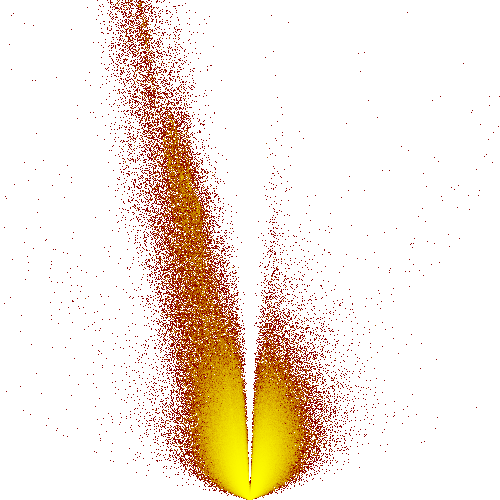

In [22]:
canvas = ds.Canvas(plot_width=500,plot_height=500, x_range=xrange,y_range=yrange)
agg = canvas.points(volc_df, 'log2fc_mean', 'log10p-value', agg=ds.count())
tf.shade(agg,cmap=["darkred","yellow"],how='eq_hist')

In [ ]:
bp.output_notebook()
TOOLS = 'pan,wheel_zoom,reset,tap'
# source = ColumnDataSource(df.query("min == 6"))
p = bp.figure(tools=TOOLS, x_range=xrange, y_range=yrange)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(pop_df, 'log2fc_mean', 'log10p-value', agg=ds.count())
    img = tf.shade(agg,cmap=["darkred","yellow"],how='eq_hist')
    return tf.dynspread(img, threshold=0.25)

InteractiveImage(p,image_callback)